In [1]:
import os                       # làm việc với hệ điều hành
import datetime                 # Lấy thời gian
from shutil import copyfile     # sao chép file, có thể dùng để lưu cấu hình.
import sys                      # thao tác với hệ thống (đường dẫn, dừng chương trình, v.v.).
import math 
import traci        
import numpy as np
import random
import timeit                   # Đo thời gian chạy của đoạn code.

import pandas as pd
from collections import defaultdict

from generator import TrafficGenerator
from memory import Memory       # Memory cho quá trình huấn luyện
from visualization import Visualization
from utils import import_train_configuration,set_sumo, set_train_path,get_model_path

import warnings                 
warnings.filterwarnings('ignore')       # Tắt bỏ qua cảnh báo trong quá trình chạt

In [2]:
# from d2l import torch as d2l  # Transformer block 
import torch 
import torch.nn as nn                       # Chứa các lớp để xây dựng mô hình mạng nơ-ron
import torch.autograd as autograd           # Dùng để tự động tính gradient khi backpropagation.
import torch.nn.functional as F             # Hàm kích hoạt và loss functions
import torch.optim as optim                 # Bộ tối ưu hoá (optimizer   )
from torch.nn.utils import clip_grad_norm_  # Giới hạn gradient (tránh gradient explosion)

In [3]:
#thiết lập thiết bị (device) mà mô hình PyTorch sẽ sử dụng để chạy – GPU hay CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

## Khai báo tham số 

In [4]:
# [simulation]
gui = False                 #Tắt/mở giao diện đồ họa của SUMO
total_episodes = 1         # Số lượng tập huấn luyện (mỗi tập là 1 lần mô phỏng giao thông)
max_steps = 3000            # Số bước thời gian trong mỗi tập (ví dụ 3600s)
n_cars_generated = 1000     # Số xe được sinh ra trong mỗi tập
green_duration = 7          # Thời gian đèn xanh
yellow_duration = 4         # Thời gian đèn vàng

# [model]
num_layers = 4              # Số lớp ẩn trong mạng nơ-ron
width_layers = 800          # Số node trong mỗi lớp ẩn
batch_size = 64             # Kích thước batch khi huấn luyện
learning_rate = 0.0001      # Tốc độ học của mô hình
training_epochs = 512       # Số epoch huấn luyện trên mỗi lần lấy mẫu từ memory
update_epochs = 10          # Cứ mỗi 10 epoch sẽ cập nhật target network
num_atoms = 51              # Số lượng atom cho DQN phân phối (Distributional DQN)
Vmin = -10                  # Giá trị tối thiểu của Q (trong C51)
Vmax = 10                   ## Giá trị tối đa của Q

# [memory]
memory_size_min = 1000      # Số lượng mẫu tối thiểu trong bộ nhớ trước khi bắt đầu train
memory_size_max = 50000     # Số lượng mẫu tối đa lưu trong bộ nhớ

# [agent]       
num_states = 1400           # Số chiều của vector trạng thái (state)
num_actions = 4             # Số hành động có thể chọn (tương ứng các pha đèn)
gamma = 0.9                 # Discount factor - tầm quan trọng của phần thưởng tương lai

# [dir] 
model_to_test = 4           # ID của mô hình cần test (nếu có)

## NoisyLinear
### Thêm nhiễu ngẫu nhiên vào weight và bias trong quá trình huấn luyện. Giúp agent khám phá tốt hơn(better exploration) trong RL. Thay thế cho epsilon-greedy

In [5]:
class NoisyLinear(nn.Module):              # Lớp kế thừa module mạng nơ ron
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        self.in_features  = in_features
        self.out_features = out_features        # Số lượng input và output node
        self.std_init     = std_init            # Độ lệch chuẩn khởi tạo cho noise
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))          # Trọng số chính (mean)
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))          # Độ lệch chuẩn trọng số. Quyết định cường độ nhiễu
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))    # Tạo tensor ma trận trọng số nhiễu [out_features, in_features]
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))                         # Bias trung bình
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))                         # Độ lệch chuẩn bias
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))                   # Tạo tensor ma trận bias nhiễu

        self.reset_parameters()
        self.reset_noise()
    
    # Hàm lan truyền (forward): Dùng để tính toán đầu ra của lớp NoisyLinear khi ta đưa đầu vào x
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))      # Cập nhật trọng số
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(self.bias_epsilon))          # Cập nhật bias
        else:
            weight = self.weight_mu 
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)    # Trả về kết quả Linear
    
    # Hàm khởi tạo giá trị ban đầu cho (mu và sig) của weight số và bias
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        # Khởi tạo weight (mu và sig)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        # Khởi tạo bias (mu và sig)
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    # Hàm tạo lại noise (được gọi trước mỗi bước huấn luyện)
    def reset_noise(self):
        # Sinh ra noisy input và output
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        # Tạo ma trận noisy của weight và bias
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    # Hàm tạo noise dạng factorized Gaussian noise thay vì Gaussion thông thường. 
    def _scale_noise(self, size):
        x = torch.randn(size)                   # Sinh vector với phân phối chuẩn
        x = x.sign().mul(x.abs().sqrt())        # Giữ hướng và thay đổi độ lớn
        return x

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if torch.cuda.is_available() else autograd.Variable(*args, **kwargs)

## Categorical & Dueling DQN 
### Dueling DQN: Phân tách giá trị trạng thái (V) và lợi ích hành động (A) để ước lượng Q tốt hơn
### Categorical DQN: Thay vì dự đoán giá trị Q, mô hình dự đoán phân phối xác suất của Q-value

In [6]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,num_layers,num_atoms):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_atoms = num_atoms
        self.support = torch.linspace(Vmin, Vmax, num_atoms).to(device) 
        
        #Mạng CNN để xử lý
        self.conv1 = nn.Conv2d(3, 16, (1,3), (1,2), padding=(0,1))
        self.conv2 = nn.Conv2d(16, 32, (2,3), (2,2), padding=(0,1))
        self.linear_c = nn.Linear(32*7*25, 4096)        # Chuyển đặc trưng từ CNN sang không gian FC
        self.linear_p = nn.Linear(4,10)                 # Mã hóa vector qua không gian 10 chiều(a, b)
        self.linear1 = nn.Linear(4096, 2048)            # Nén đặc trưng c 
        self.linear2 = NoisyLinear(2068, 1024)          # 2068 = 2048 + 10 + 10. Đưa vào Noisy để sinh đặc trưng ngẫu nhiên
        self.linear3 = NoisyLinear(2068, 1024)
        # Dự đoán phân phối xác suất của Q-values
        self.linear_A = NoisyLinear(1024, self.output_size*self.num_atoms)      # Dự đoán phân phối Advantage A(s, a) cho tất cả các hành động.
        self.linear_V = NoisyLinear(1024, 1*self.num_atoms)                     # Dự đoán phân phối Value V(s) – tức là giá trị tổng quát của trạng thái (không phụ thuộc vào hành động nào cụ thể).
    
    # Hàm truyền thẳng
    def forward(self, s,a,b):
        dist = self.dist(s,a,b)     # Phân phối xác suất của Q-Values
        q = torch.sum(dist*self.support, dim=2)     # Tính giá trị Q kỳ vọng
        return q
    # Tính phân phối xác suất Q-Values 
    def dist(self, s,a,b):
        x = F.relu(self.conv2(F.relu(self.conv1(s))))       # Trích suất đặc trưng không gian từ ảnh
        x = x.view(-1, 32*7*25)                             # Từ conv2 đưa vào fully connected layyer
        x = F.relu(self.linear1(F.relu(self.linear_c(x))))  # giảm chiều tăng biểu diễn phi tuyến 
        a = torch.tensor(a,dtype=torch.float).view(-1,4)
        b = torch.tensor(b,dtype=torch.float).view(-1,4)
        a = F.relu(self.linear_p(a)).view(-1,10)
        b = F.relu(self.linear_p(b)).view(-1,10) 
        x = torch.cat([x,a,b],dim=1).view(-1,2068)
        V = self.linear_V(F.relu(self.linear2(x)))          # Dueling network tách 2 nhánh 
        A = self.linear_A(F.relu(self.linear3(x)))          # Dự đoán phân phối
        V = V.view(-1,1,self.num_atoms)
        A = A.view(-1,self.output_size,self.num_atoms)
        q = V + A - A.mean(dim=1, keepdim=True)             # Tính phân phối Q-Values rời rạc
        
        dist = F.softmax(q,dim=-1)
        dist = dist.clamp(min=1e-3)                         # Tránh Nal khi Log(dist)
        return dist
    # Khởi tạo nhiễu trong các lớp NoisyLinear 
    def reset_noise(self):
        self.linear2.reset_noise()
        self.linear3.reset_noise()
        self.linear_A.reset_noise()
        self.linear_V.reset_noise()

# DQN Framework --> Rainbow
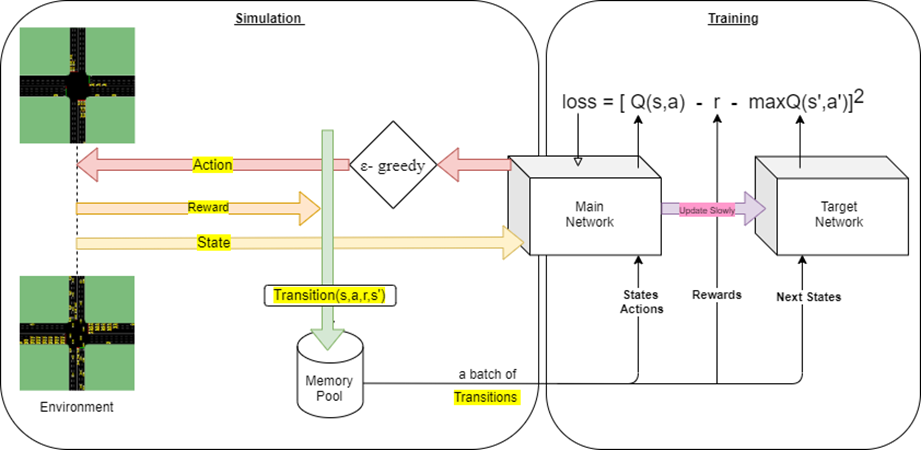


## 3-Step TD Learning
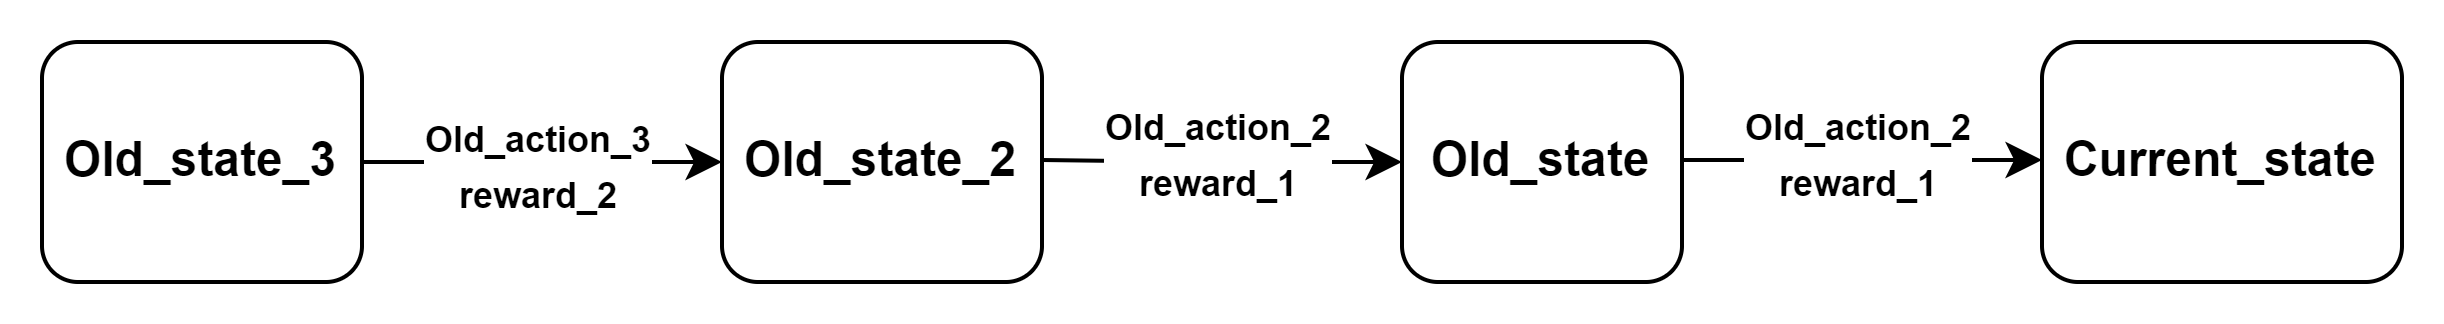

- Paper link: 

## Phase Setting based on Environment

In [7]:
# phase codes based on SUMO environment.net.xml 
PHASE_NS_GREEN = 0      # Pha đèn xanh cho hướng Bắc-Nam (North-South) — tương ứng action 0
PHASE_NS_YELLOW = 1     # Pha đèn vàng cho hướng Bắc-Nam
         
PHASE_NSL_GREEN = 2     # Pha đèn xanh cho hướng Bắc-Nam có rẽ trái (NS-Left) — action 1
PHASE_NSL_YELLOW = 3    # Pha đèn vàng cho NS có rẽ trái

PHASE_EW_GREEN = 4      # Pha đèn xanh cho hướng Đông-Tây (East-West) — action 2
PHASE_EW_YELLOW = 5     # Pha đèn vàng cho Đông-Tây

PHASE_EWL_GREEN = 6     # Pha đèn xanh cho hướng Đông-Tây có rẽ trái (EW-Left) — action 3
PHASE_EWL_YELLOW = 7    # Pha đèn vàng cho EW có rẽ trái


Duration_NS = 18
Duration_NSL = 7
Duration_EW = 16
Duration_EWL = 7


O = [Duration_NS,Duration_NSL,Duration_EW,Duration_EWL]
duration = [Duration_NS,Duration_NSL,Duration_EW,Duration_EWL]
old_duration = [Duration_NS,Duration_NSL,Duration_EW,Duration_EWL]

## Biểu diễn trạng thái 
###     * Lấy trạng thái của ngã tư giao thông từ mô phỏng SUMO.
###     * Trạng thái được biểu diễn bằng cách chia nhỏ mỗi làn xe thành các ô (cell) theo chiều dài.
###     * Rồi ghi lại 3 thông tin tại mỗi cell: có xe không, tốc độ xe, và thời gian chờ.

In [8]:
def _get_state():
    # Khởi tạo ma trận trạng thái dạng DTSE (Discrete Traffic State Encoding)
    # 3 channel: [0] là occupancy (1 nếu có xe), [1] là tốc độ, [2] là thời gian chờ
    # 14 lane × 100 cell trên mỗi lane 
    state = np.zeros((3,14,100))
    
    # Danh sách ID của các làn xe (tên làn kết nối đến đèn giao thông)
    lane = ["N2TL_0","N2TL_1","N2TL_2","E2TL_0","E2TL_1","E2TL_2","E2TL_3","S2TL_0","S2TL_1","S2TL_2","W2TL_0","W2TL_1","W2TL_2","W2TL_3"]
    car_list = traci.vehicle.getIDList()        # Lấy danh sách ID các xe đang xuất hiện
    lane_group = 0                              # Biến tạm để xác định vị trí của xe thuộc làn nào trong danh sách 14 làn
    # waiting_dict = {}

    # Duyệt qua từng xe trong mô phỏng
    for car_id in car_list:
        lane_pos = traci.vehicle.getLanePosition(car_id)            # Vị trí hiện tại của xe trên làn (tính từ đầu làn)
        car_speed = traci.vehicle.getSpeed(car_id)                  # Tốc độ hiện tại của xe
        lane_id = traci.vehicle.getLaneID(car_id)                   # Làn mà xe đang chạy trên đó
        lane_pos = 750 - lane_pos                                   # Đảo chiều vị trí: nếu xe càng gần đèn → lane_pos càng nhỏ (0 ~ 750)
        
        lane_cell = int(lane_pos/7.5)                               # Chia làn xe thành các ô (cell) 7.5m → mapping vị trí thành chỉ số cell

        # Tìm chỉ số tương ứng của lane hiện tại trong danh sách 14 lane
        for i in range(len(lane)):
            if lane_id == lane[i]:
                lane_group = i

        # Ghi thông tin vào 3 channel:
        # Channel 0: Có xe hay không → 1
        state[0][lane_group][lane_cell] = 1
        # Channel 1: Tốc độ của xe tại cell đó
        state[1][lane_group][lane_cell] = car_speed
        # Channel 2: Thời gian chờ tích luỹ của xe tại cell đó
        state[2][lane_group][lane_cell] = traci.vehicle.getAccumulatedWaitingTime(car_id)   

        # Lấy thời gian chờ của từng làn
        # waiting_time = traci.lane.getWaitingTime(laneID=lane_id)
        # waiting_dict[lane_id] = + waiting_time

        
    return state.tolist()       # Trả về dưới dạng list để phù hợp với input cho mô hình

# Chạy SUMO-GUI với điều khiển đèn giao thông tĩnh

In [9]:
def run_static_simulation_for_epoch(sumo_cmd, max_steps, output_dir="static_results", episode=0):
    os.makedirs(output_dir, exist_ok=True)

    traci.start(sumo_cmd)
    print(f"Static Simulation (no DQN) — Episode {episode+1}")

    total_queue = 0
    total_speed = 0
    step_count  = 0

    # vehicle_speeds = defaultdict(dict)  # {vehicle_id: {step: speed}}

    for step in range(max_steps):
        traci.simulationStep()

        # vehicle_ids = traci.vehicle.getIDList()
        # for vid in vehicle_ids:
        #     speed = traci.vehicle.getSpeed(vid)
        #     vehicle_speeds[vid][step] = speed
        # Tính số xe đang dừng (queue length)
        queue_step = 0
        for vid in traci.vehicle.getIDList():
            if traci.vehicle.getWaitingTime(vid) > 0:
                queue_step += 1
        total_queue += queue_step

        # Tính tốc độ trung bình
        speeds = [traci.vehicle.getSpeed(vid) for vid in traci.vehicle.getIDList()]
        if speeds:
            total_speed += sum(speeds) / len(speeds)
        step_count += 1

    traci.close()

    # Chuyển sang DataFrame: index là step, cột là vehicle
    # df = pd.DataFrame(vehicle_speeds)  # step x vehicle
    # df.index.name = "step"

    # # Sắp xếp theo step tăng dần
    # df = df.sort_index()

    # # Lưu CSV
    # output_csv = os.path.join(output_dir, f"vehicle_speeds_matrix_ep{episode+1}.csv")
    # df.to_csv(output_csv, float_format="%.2f")

    # Trung bình theo bước
    avg_speed = total_speed / step_count if step_count > 0 else 0

    # Ghi vào 2 file riêng biệt (append theo từng epoch)
    with open(os.path.join(output_dir, "static_total_queue.txt"), "a") as f:
        f.write(f"{total_queue}\n")

    with open(os.path.join(output_dir, "static_avg_speed.txt"), "a") as f:
        f.write(f"{avg_speed:.6f}\n")

    print(f"Total Queue: {total_queue}    Average Speed: {avg_speed:.4f}")
    return total_queue, avg_speed           #, vehicle_speeds


# 1. Simulation DQN
### - Khởi tạo mô phỏng
### -   Vận hành mô phongr giao thông
### -   Tính toán phần thưởng
### -   Lưu kinh nghiệm vào bộ nhớ
### -   Huấn luyện mô hình DQN

In [10]:
#lõi điều khiển mô phỏng và huấn luyện cho bài toán DQN điều khiển đèn giao thông trong môi trường SUMO.
class Simulation:
    def __init__(self, Model, Memory, TrafficGen, sumo_cmd, gamma, max_steps, green_duration, yellow_duration, num_states, num_actions):
        self._model = Model
        self._Model_A = Model.critic
        self._Model_B = Model.critic_target
        self._Memory = Memory
        self._TrafficGen = TrafficGen
        self._gamma = gamma
        self._step = 0
        self._sumo_cmd = sumo_cmd
        self._max_steps = max_steps 
        self._green_duration = green_duration
        self._yellow_duration = yellow_duration
        self._num_states = num_states
        self._num_actions = num_actions
        self._reward_store = []
        self._speed_store = []
        self._cumulative_wait_store = []
        self._avg_queue_length_store = []

    # Chạy mô phỏng SUMO trong một tập: Lấy trạng thái từ môi trường, Chọn hành động với DQN(random hoặc theo epsilon), Gửi hành động vào SUMO-GUI, Tính phần thưởng, Ghi lại vào bộ nhớ và Lưu thống kê kết thúc tập luyện
    def run(self, episode, epsilon):
        if "default" in traci.connection._connections:
            print("Detected open TraCI connection. Closing it before starting a new one...")
            try:
                traci.close()
            except:
                print("Warning: Failed to close TraCI connection. You may need to restart the kernel.")
                return 0
        self.training = False

        start_time = timeit.default_timer()                 # Lấy thời gian bắt đầu mô phỏng

        self._TrafficGen.generate_routefile(seed=episode)   # Tạo phương tiện mô phỏng
        traci.start(self._sumo_cmd)                         
        print("Simulating...")

        # Khởi tạo
        self._step = 0
        self._waiting_times = {}
        self._sum_neg_reward = 0
        self._sum_queue_length = 0
        self._sum_waiting_time = 0
        self._sum_speed = 0
        old_action = 0
        reward = 0
        re = 0
        current_phase = 0
        self.reward = 0
        duration = [0,0,0,0]
        old_duration = [0,0,0,0]
        old_duration_2 = [0,0,0,0]
        old_duration_3 = [0,0,0,0]
        old_action_2 = 0
        old_action_3 = 0
        reward_1 = 0
        reward_2 = 0
        x = [0,0,0,0]
        x_1 = [0,0,0,0]
        x_2 = [0,0,0,0]
        x_3 = [0,0,0,0]
        
        self._simulate(50)          # Khởi động môi trường. Trước khi đi vào huấn luyện
        old_state = _get_state()
        old_state_2 = _get_state()
        old_state_3 = _get_state()

        # vehicle_speeds = defaultdict(dict)  # {vehicle_id: {step: speed}}

        while self._step < self._max_steps:
            current_state = _get_state()                                # Lấy trạng thái thông tin hiện tại của gia lộ
            current_total_wait = self._collect_waiting_times()          # Tính thời gian chờ = số giây xe chờ kể từ khi xuất hiện trong môi trường, tích lũy cho mỗi xe trong làn đường đến
            reward = - current_total_wait                               # Phần thưởng được tính bằng giá trị âm tổng thời gian chờ
            current_phase = int(traci.trafficlight.getPhase("TL")/2)    # Xác định pha đèn hiện tại
            phase = current_phase - 1
            if phase == -1:
                phase = 3
                
            action = self._choose_action(current_state, epsilon,current_phase,duration)     # Chọn hành động
            # Lưu kinh nghiệm vào bộ nhớ
            if self._step != 0:
                x = [0,0,0,0]               # Biểu diễn old_action (Onehot)
                y = [0,0,0,0]               # Biểu diễn action
                x[old_action] = 1
                y[action] = 1         
                # Tính TD và lưu mẫu vào Memory
                if self._step < self._max_steps - self._green_duration - self._yellow_duration:
                    TD = self._model.get_TD(old_state_3,old_action_3,reward_2,reward_1,reward,current_state,0,x_3,y,old_duration_3,duration).squeeze(0).detach().tolist()
                    self._Memory.add_sample(TD, (old_state_3,old_action_3,reward_2,reward_1,reward,current_state,0,x_3,y,old_duration_3,duration))
                else:
                    TD = self._model.get_TD(old_state_3,old_action_3,reward_2,reward_1,reward,current_state,1,x_3,y,old_duration_3,duration).squeeze(0).detach().tolist()
                    self._Memory.add_sample(TD, (old_state_3,old_action_3,reward_2,reward_1,reward,current_state,1,x_3,y,old_duration_3,duration))
            # Điều khiển pha đèn
            if self._step != 0 and old_action != action:            # Nếu agent chọn pha đèn khác pha hiện tại -> Chuyển pha
                self._set_yellow_phase(current_phase)
                self._simulate(self._yellow_duration)
                duration[action] = self._green_duration
            else:                                                   # Nếu không giữ pha và + thêm
                duration[action] += 7
                
            self._set_green_phase(action)
            self._simulate(self._green_duration)

            # Lưu lại lịch sử trạng thái, hành động, thời lượng và phần thưởng. Học qua nhiều bước multi-step
            old_state_3 = old_state_2
            old_state_2 = old_state
            old_state = current_state
            old_action_3 = old_action_2
            old_action_2 = old_action
            old_action = action
            #Lưu thông tin vector pha đèn
            x_3 = x_2
            x_2 = x_1
            x_1 = x
            old_duration_3 = old_duration_2
            old_duration_2 = old_duration
            old_duration = duration
            reward_2 = reward_1
            reward_1 = reward

            # chỉ lưu phần thưởng có ý nghĩa để xem rõ hơn liệu tác nhân có hành xử đúng đắn hay không
            # if reward < 0:
            self._sum_neg_reward += reward          # Tổng reward trong 1 epoch
            re += 1                     
            self.reward = self._sum_neg_reward/re   # Phần thưởng trung bình trong một bước mô phỏng
                
        print("Total Queue:",self._sum_queue_length, "  ", "Average Reward:", self.reward, " ", "Average Speed:",self._sum_speed/self._max_steps)

        self._save_episode_stats()                  # Lưu thống kê vào bộ nhớ
        print("Total Reward:", self._sum_neg_reward, "- Epsilon:", round(epsilon, 2))
        traci.close()

        simulation_time = round(timeit.default_timer() - start_time, 1)
        print("Simulation time per epoch: ", simulation_time, "\n")
        return simulation_time

    # Chạy mô phỏng từng bước
    def _simulate(self, steps_todo):
        if (self._step + steps_todo) >= self._max_steps:  # không thực hiện nhiều bước hơn số bước tối đa được phép
            steps_todo = self._max_steps - self._step

        while steps_todo > 0:
            traci.simulationStep()  # simulate 1 step in sumo
            self._step += 1         # cập nhật bộ đếm bước
            steps_todo -= 1         # steps_todo = được giảm đi 1
            queue_length = self._get_queue_length()             # Lấy số lượng xe đang dừng
            self._sum_queue_length += queue_length              # Tổng
            self._sum_waiting_time += queue_length              # 1 bước trong khi chờ đợi trong hàng đợi có nghĩa là phải chờ 1 giây cho mỗi xe, do đó queue_lenght == wait_seconds
            speed = self._get_speed()                           # Tốc độ trùng bình của các xe đang chạt ở step hiện tại
            self._sum_speed += speed
        
    # Thu thập thời gian chờ trung bình của các xe trên đường vào giao lộ
    def _collect_waiting_times(self):
        incoming_roads = ["E2TL", "N2TL", "W2TL", "S2TL"]
        car_list = traci.vehicle.getIDList()
        self._waiting_times = {}                # Khởi tạo dict lưu thời gian chờ của từng xe.
        for car_id in car_list:
            wait_time = traci.vehicle.getAccumulatedWaitingTime(car_id)         # Lấy thời gian chờ của từng xe
            road_id = traci.vehicle.getRoadID(car_id)                           # lấy ID Road nơi xe đang ở
            if road_id in incoming_roads:                                       # Ghi thông tin vào 
                self._waiting_times[car_id] = wait_time 
            else:
                if car_id in self._waiting_times:                               # Nếu xe không còn nằm trong incoming_road -> del thông tin nó đi
                    del self._waiting_times[car_id] 
                
        if len(self._waiting_times) == 0: 
            total_waiting_time = 0
        else: 
            total_waiting_time = sum(self._waiting_times.values())/len(self._waiting_times)
        return total_waiting_time 

    # Lựa chọn hành động
    def _choose_action(self, state, epsilon,phase,old_duration):
        if random.random() < epsilon:       
            return random.randint(0, self._num_actions - 1)                 # Chọn hành động ngẫu nhiên từ [0, num_actions-1]
        else:
            x = [0,0,0,0]
            x[phase] = 1
            return torch.argmax(self._model.predict(state,x,old_duration))  # hành động tốt nhất cho trạng thái hiện tại
    # Thiết lập đèn vàng cho mô phỏng
    def _set_yellow_phase(self, old_action): 
        yellow_phase_code = old_action * 2 + 1                              # lấy mã pha màu vàng, dựa trên hành động cũ (tham khảo trên environment.net.xml)
        traci.trafficlight.setPhase("TL", yellow_phase_code)
    # Thiết lập đèn xanh cho mô phỏng
    def _set_green_phase(self, action_number): 
        if action_number == 0:
            traci.trafficlight.setPhase("TL", PHASE_NS_GREEN)
        elif action_number == 1:
            traci.trafficlight.setPhase("TL", PHASE_NSL_GREEN)
        elif action_number == 2:
            traci.trafficlight.setPhase("TL", PHASE_EW_GREEN)
        elif action_number == 3:
            traci.trafficlight.setPhase("TL", PHASE_EWL_GREEN)
    # Nhận đèn xanh
    def _get_green(self,current_phase):       
        if current_phase == 0:
            green = Duration_NS
        elif current_phase == 1:
            green = Duration_NSL
        elif current_phase == 2:
            green = Duration_EW
        else: 
            green = Duration_EWL
        return green
    # Đo tổng số phương tiện dừng lại trong 4 làn đường tại nút giao thông
    def _get_queue_length(self):
        halt_N = traci.edge.getLastStepHaltingNumber("N2TL")        # Trả về số xe đang dừng
        halt_S = traci.edge.getLastStepHaltingNumber("S2TL")
        halt_E = traci.edge.getLastStepHaltingNumber("E2TL")
        halt_W = traci.edge.getLastStepHaltingNumber("W2TL")
        queue_length = halt_N + halt_S + halt_E + halt_W
        return queue_length
    # Tính tốc độ trung bình của phương tiện trong mô phỏng tại thời điểm hiện tại
    def _get_speed(self):      
        total_speed = 0
        car_list = traci.vehicle.getIDList()
        for car_id in car_list:
            car_speed = traci.vehicle.getSpeed(car_id)
            total_speed += car_speed
        if len(car_list) == 0: 
            s = 0
        else: 
            s = total_speed/len(car_list)
        return s
    # Lưu lại các chỉ số hiệu suất (reward, tốc độ, hàng đợi, thời gian chờ) của một tập (episode) mô phỏng để phục vụ việc vẽ biểu đồ hoặc đánh giá sau huấn luyện.
    def _save_episode_stats(self):
        self._reward_store.append(self.reward)
        self._speed_store.append(self._sum_speed / self._max_steps)
        self._cumulative_wait_store.append(self._sum_waiting_time)
        self._avg_queue_length_store.append(self._sum_queue_length / self._max_steps)
    
    # Lưu lại, chỉ đọc và được truy cập bên ngoài lớp Simulation
    @property
    def reward_store(self):
        return self._reward_store

    @property
    def speed_store(self):
        return self._speed_store
    
    @property
    def cumulative_wait_store(self):
        return self._cumulative_wait_store

    @property
    def avg_queue_length_store(self):
        return self._avg_queue_length_store

# 2. Training

### - Lấy mẫu từ bộ nhớ (Replay Buffer)
### - Tính toán sai số TD (Temporal Difference Error)
### - Huấn luyện mô hìnhcritic (DQN)
### - Cập nhật tham số mạng
### - Cập nhật độ ưu tiên của mẫu trong Replay Buffer (nếu dùng Prioritized Experience Replay)

In [11]:
# nơi thực hiện quá trình huấn luyện (training) mô hình DQN dựa trên các mẫu được lấy từ bộ nhớ (Replay Buffer).
class Training:
    def __init__(self, Model, Memory, training_epochs, update_epochs, batch_size):
        self._model = Model
        self._Model_A = Model.critic
        self._Model_B = Model.critic_target
        self._Memory = Memory
        self._loss_store = []
        self._batch_size = batch_size
        self.history = 0
        self.loss_value = 0         # loss của toàn bộ quá trình huấn luyện
    
    # Hàm chính để huấn luyện mô hình
    def run(self):
        self.training = True
        print("Training...")
        start_time = timeit.default_timer()
        self.loss_value = 0
        
        for _ in range(training_epochs):
            self.experience_replay()
            self.loss_value += self.history
            if ( _ / update_epochs == 0):
                self._model._update_model()
        self.loss_value = torch.tensor(self.loss_value)
        self._save_loss()
        print("loss:",self.loss_value)
        training_time = round(timeit.default_timer() - start_time, 1)
        
        return training_time
    
    # Lấy mẫu & train model
    def experience_replay(self):
        batch, idxs, is_weights = self._Memory.get_samples(self._batch_size) 
    
        if len(batch) > 0:  # Kiểm tra bộ nhớ có đủ dữ liệu không
            old_states_3 = torch.tensor(([val[0] for val in batch]),dtype=torch.float).to(device) 
            old_actions_3 = torch.tensor(([val[1] for val in batch]),dtype=torch.int64).to(device)
            rewards_2 = torch.tensor(([val[2] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            rewards_1 = torch.tensor(([val[3] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            rewards = torch.tensor(([val[4] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            next_states = torch.tensor(([val[5] for val in batch]),dtype=torch.float).to(device)  
            dones = torch.tensor(([val[6] for val in batch]),dtype=torch.float).reshape(-1,1).to(device)
            a = torch.tensor(([val[7] for val in batch]),dtype=torch.float).to(device)
            b = torch.tensor(([val[8] for val in batch]),dtype=torch.float).to(device)
            c = torch.tensor(([val[9] for val in batch]),dtype=torch.float).to(device)
            d = torch.tensor(([val[10] for val in batch]),dtype=torch.float).to(device)
            weights = torch.tensor((is_weights),dtype=torch.float).reshape(-1,1).to(device)
            
            ## Huấn luyện mạng  và update 
            self.history,TD = self._model.critic_learn(old_states_3,old_actions_3,rewards_2,rewards_1,rewards,next_states,dones,a,b,c,d,weights) 
            # Xử lý loss và TD
            self.history = self.history.to("cpu").squeeze(0).detach() 
            TD = TD.squeeze(0).detach().tolist()
            # Cập nhật độ ưu tiên cho từng mẫu
            for i in range(len(batch)): 
                idx = idxs[i]
                td = TD[i]  
                self._Memory.update(idx,td)
            #  Reset noise
            self._Model_A.reset_noise()
            self._Model_B.reset_noise()
                    
    # Lưu giá trị loss mỗi lần huấn luyện
    def _save_loss(self):
        self._loss_store.append(self.loss_value)

    @property
    def loss_store(self):
        return self._loss_store

## Deep Reinforcement Learning Algorithm

### Categorical DQN
#### Categorical DQN (C51) — một cải tiến của DQN, nơi mà thay vì chỉ dự đoán giá trị kỳ vọng (expected Q-value), mô hình sẽ dự đoán phân phối xác suất trên các giá trị phần thưởng có thể xảy ra.

In [12]:
# thực hiện phép chiếu phân phối Q-value ở bước tiếp theo về phân phối mục tiêu tại bước hiện tại.
def projection_distribution(ns, r2,r1,r, dones,b,d):
    with torch.no_grad():               # Không tính gradient vì đây là bước target
        batch_size  = ns.size(0)        # Lấy kích thước batch
        # Tính khoảng cách giữa các atom (khoảng cách giữa các giá trị rời rạc)
        delta_z = float(Vmax - Vmin) / (num_atoms - 1)
        support = torch.linspace(Vmin, Vmax, num_atoms).to(device)
        # Chọn hành động tối ưu từ critic_target (dựa trên Q-value trung bình)
        next_action = Model.critic_target(ns,b,d).argmax(1)
        # Lấy distribution tương ứng với action đó
        next_dist = Model.critic_target.dist(ns,b,d)
        next_dist = next_dist[range(batch_size),next_action]
        # Tz = rewards + (1 - dones) * gamma * support
        Tz = r2+gamma*r1+gamma**2*r + gamma**3 * support * (1-dones)
        Tz = Tz.clamp(min=Vmin, max=Vmax)
        b  = (Tz - Vmin) / delta_z
        l  = b.floor().long()
        u  = b.ceil().long()

        offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                        .unsqueeze(1).expand(batch_size, num_atoms).to(device)
        # Khởi tạo distribution chiếu mới
        proj_dist = torch.zeros(next_dist.size()).to(device)    
        # Chiếu phân phối về hai phía (phân phối lại xác suất)
        proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
        proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist        # Kết quả là phân phối xác suất target cho mỗi mẫu

### 3. TD Learning
#### Mạng chính critic và mạng mục tiêu critic_target
#### Cập nhật trọng số
#### Huấn luyện với projection distribution
#### Tính TD-error cho prioritized replay
#### Dự đoán giá trị Q
#### Lưu và tải mô hình

In [ ]:
# Lớp DRL_Model là trung tâm huấn luyện và xử lý logic học sâu trong mô hình DQN bạn đang triển khai
class DRL_Model():
    def __init__(self, num_layers, width, batch_size, learning_rate, input_dim, output_dim, tau,num_atoms):
        self._i_dim = (3,14,100) #input_dim
        self._o_dim = output_dim
        self.critic_lr = learning_rate
        self.tau = tau
        self.batch_size = batch_size
        
        self.critic = Critic(self._i_dim, width, self._o_dim, num_layers,num_atoms)
        self.critic_target = Critic(self._i_dim, width, self._o_dim, num_layers,num_atoms)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr = self.critic_lr)
        self._update_model()
        self.critic.to(device)
        self.critic_target.to(device)
     
    ## DQN Algorithm 
    def critic_learn(self,s3,a3,r2,r1,r,ns,done,a,b,c,d,weights):     
        proj_dist = projection_distribution(ns, r2,r1,r, done,b,d)
        dist = self.critic.dist(s3,a,c) 
        log_p = torch.log(dist[range(batch_size),a3]) 
        elementwise_loss = - (Variable(proj_dist) * log_p).sum(1)
        TD = elementwise_loss.detach()
        loss = torch.mean(weights * elementwise_loss) 
        
        self.critic_optim.zero_grad()
        loss.backward()
        clip_grad_norm_(self.critic.parameters(), 10.0)
        self.critic_optim.step()
        return loss,TD
    
    # Tính TD-error cho Prioritized Replay
    def get_TD(self,s3,a3,r2,r1,r,ns,done,a,b,c,d, alpha=0.6):
        s3 = torch.tensor(s3,dtype=torch.float).reshape(-1,3,14,100).to(device)
        ns = torch.tensor(ns,dtype=torch.float).reshape(-1,3,14,100).to(device)
        a = torch.tensor(a,dtype=torch.float).to(device)
        b = torch.tensor(b,dtype=torch.float).to(device)
        c = torch.tensor(c,dtype=torch.float).to(device)
        d = torch.tensor(d,dtype=torch.float).to(device)
        done = torch.tensor(done,dtype=torch.float).reshape(-1,1).to(device)
        a3 = torch.tensor(a3,dtype=torch.int64).reshape(-1,1).to(device)
        r2 = torch.tensor(r2,dtype=torch.float).to(device)
        r1 = torch.tensor(r1,dtype=torch.float).to(device)
        r = torch.tensor(r,dtype=torch.float).to(device)
        # Phân phối mục tiêu
        proj_dist = projection_distribution(ns, r2,r1,r, done,b,d)
        dist = self.critic.dist(s3,a,c)
        # Chọn phân phối tương ứng với hành động đã thực hiện
        action = a3.unsqueeze(1).expand(s3.shape[0], 1, num_atoms)
        dist = dist.gather(1, action).squeeze(1)
        dist.data.clamp_(0.01, 0.99)
        log_p = dist.log() 
        # Tính toán TD-error bằng cross-entropy giữa 2 phân phối
        elementwise_loss = - (Variable(proj_dist) * log_p).sum(1)
        elementwise_loss = elementwise_loss.mean()
        TD = elementwise_loss
        
        return TD
    
    # Dự đoán giá trị Q của một trạng thái
    def predict(self, s,a,c):
        s = torch.tensor(s, dtype=torch.float).unsqueeze(0).to(device)
        a = torch.tensor(a,dtype=torch.float).to(device)
        c = torch.tensor(c,dtype=torch.float).to(device)
        return self.critic(s,a,c).squeeze(0).detach()
        
    # Đồng bộ hóa mạng mục tiêu 
    def _update_model(self):
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_target.eval()

    # Cập nhật mô hình mục tiêu mềm                           
    def soft_update(self,net_target, net):
        for target_param, param  in zip(net_target.parameters(), net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)
        self.critic_target.eval()
        
    # Load/Save model
    def _load_my_model(self, model_folder_path):
        model_file_path = os.path.join(model_folder_path, 'trained_model.pth')

        if os.path.isfile(model_file_path):
            checkpoint = torch.load(model_file_path, map_location=device)
            
            self.critic.load_state_dict(checkpoint['critic'])
            self.critic_target.load_state_dict(checkpoint['critic_target'])
            self.critic_optim.load_state_dict(checkpoint['optim'])

            self.tau = checkpoint.get('tau', self.tau)
            self.batch_size = checkpoint.get('batch_size', self.batch_size)

            self.critic.to(device)
            self.critic_target.to(device)
            print("Load model successfully!")
        else:
            sys.exit("Model not found at {}".format(model_file_path))
            
    def save_model(self, path):
        os.makedirs(path, exist_ok=True)
        torch.save({
            'critic': self.critic.state_dict(),
            'critic_target': self.critic_target.state_dict(),
            'optim': self.critic_optim.state_dict(),
            'tau': self.tau,
            'batch_size': self.batch_size
        }, os.path.join(path, 'trained_model.pth'))

In [14]:
import matplotlib.pyplot as plt

def plot_all_vehicle_speeds(vehicle_speeds):
    """
    Vẽ biểu đồ tốc độ của tất cả phương tiện qua các bước mô phỏng.

    Args:
        vehicle_speeds: dict {vehicle_id: {step: speed}}
    """
    plt.figure(figsize=(14, 7))

    for vehicle_id, step_speeds in vehicle_speeds.items():
        steps = sorted(step_speeds.keys())
        speeds = [step_speeds[step] for step in steps]
        plt.plot(steps, speeds, label=vehicle_id, linewidth=1)

    plt.xlabel("Simulation Step", fontsize=12)
    plt.ylabel("Speed (m/s)", fontsize=12)
    plt.title("Speeds of All Vehicles Over Time", fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Nếu quá nhiều xe thì không hiển thị legend
    if len(vehicle_speeds) <= 20:
        plt.legend(fontsize=8)

    plt.show()


# 3. Run và hiển thị kết quả

In [15]:
# Đoạn mã if __name__ == "__main__": là phần chạy chính của chương trình huấn luyện mô hình DQN điều khiển đèn giao thông với SUMO.

if __name__ == "__main__":
    config = import_train_configuration(r"D:\SUMO_CaiDat\StageLight-main\StageLight-main\training_settings.ini")
    sumocfg_path = r"D:\SUMO_CaiDat\StageLight-main\StageLight-main\interesection\sumo_config.sumocfg"
    sumo_cmd = set_sumo(gui=True, sumocfg_file_name=sumocfg_path, max_steps=max_steps)
    path = set_train_path("models")
    model_path = get_model_path(config['models_path_name'], model_to_test)

    Model = DRL_Model(num_layers, width_layers, batch_size, learning_rate, input_dim=num_states, output_dim=num_actions,tau=1,num_atoms=num_atoms)

    memory = Memory(memory_size_max, memory_size_min)

    TrafficGen = TrafficGenerator(max_steps, n_cars_generated)

    visualizer  = Visualization(path, dpi=96)
        
    simulation = Simulation(Model,memory,TrafficGen,sumo_cmd,gamma,max_steps,green_duration,yellow_duration,num_states,num_actions)
  
    training = Training(Model,memory,training_epochs,update_epochs,batch_size)
    
    episode = 0
    timestamp_start = datetime.datetime.now()
     
    Model._load_my_model(model_path)
    
    # traci.close() 
    while episode < total_episodes:
        print('\n----- Episode', str(episode+1), 'of', str(total_episodes))
        epsilon = (1.0 - ((episode+1) / total_episodes))  # set the epsilon for this episode according to epsilon-greedy policy epsilon = 0
        total_queue, avg_speed = run_static_simulation_for_epoch(sumo_cmd, max_steps=max_steps, output_dir="static_results", episode=episode)
        # plot_all_vehicle_speeds(vehicle_speeds=vehicle_speeds)

        simulation_time = simulation.run(episode, epsilon)  # run the simulation
        # plot_all_vehicle_speeds(vehicle_speeds=vehicle_speeds_1)
        
        training_time = training.run()                      # train the model  
        print('Simulation time:', simulation_time, 's - Training time:', training_time, 's - Total:', round(simulation_time+training_time, 1), 's')
        episode += 1
        
    print("\n----- Start time:", timestamp_start)
    print("----- End time:", datetime.datetime.now())
    print("----- Session info saved at:", path)

    Model.save_model(path)

    copyfile(src=r"D:\SUMO_CaiDat\StageLight-main\StageLight-main\training_settings.ini", dst=os.path.join(path, 'training_settings.ini'))

Load model successfully!

----- Episode 1 of 1
Static Simulation (no DQN) — Episode 1
Total Queue: 81950    Average Speed: 5.9194
Simulating...
Total Queue: 160490    Average Reward: -69.37078509276272   Average Speed: 3.7811572241356863
Total Reward: -26014.044409786016 - Epsilon: 0.0
Simulation time per epoch:  139.7 

Training...


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_all_vehicle_speeds(vehicle_speeds):
    """
    Vẽ biểu đồ tốc độ của tất cả phương tiện qua các bước mô phỏng.

    Args:
        vehicle_speeds: dict {vehicle_id: {step: speed}}
    """
    plt.figure(figsize=(14, 7))

    for vehicle_id, step_speeds in vehicle_speeds.items():
        steps = sorted(step_speeds.keys())
        speeds = [step_speeds[step] for step in steps]
        plt.plot(steps, speeds, label=vehicle_id, linewidth=1)

    plt.xlabel("Simulation Step", fontsize=12)
    plt.ylabel("Speed (m/s)", fontsize=12)
    plt.title("Speeds of All Vehicles Over Time", fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Nếu quá nhiều xe thì không hiển thị legend
    if len(vehicle_speeds) <= 20:
        plt.legend(fontsize=8)

    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\SUMO_CaiDat\\StageLight-main\\StageLight-main\\models\\model_5\\plot_reward.png'

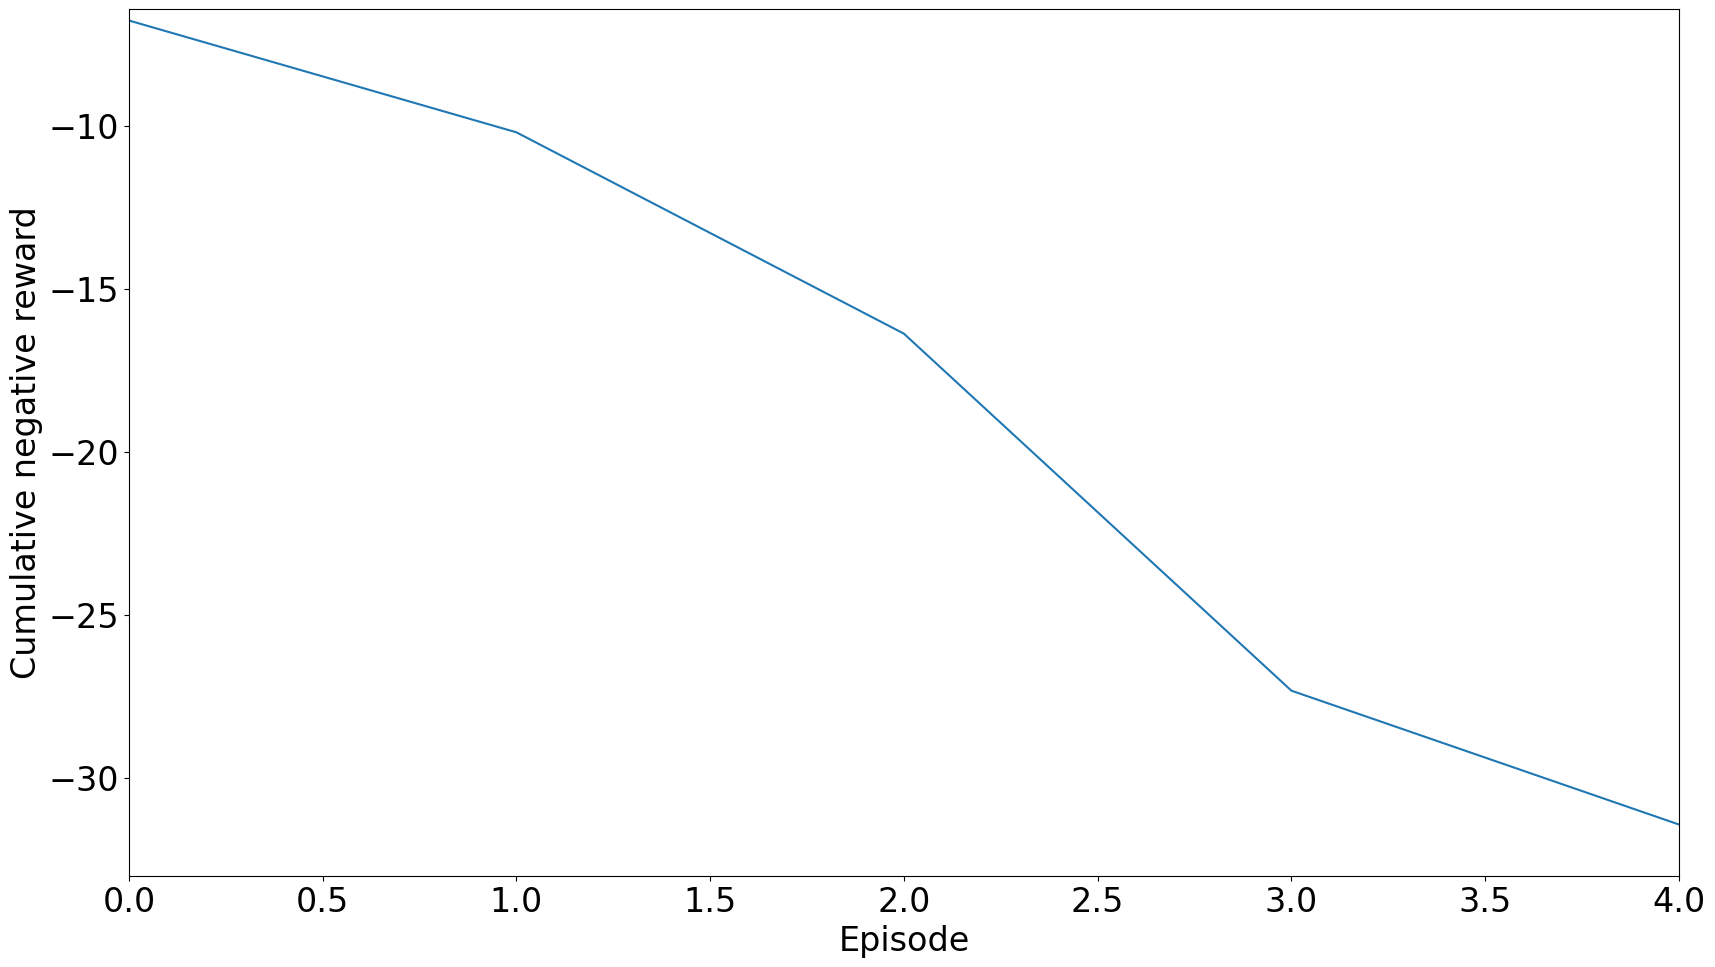

In [ ]:
visualizer.save_data_and_plot(data=Simulation.reward_store, filename='reward', xlabel='Episode', ylabel='Cumulative negative reward')  

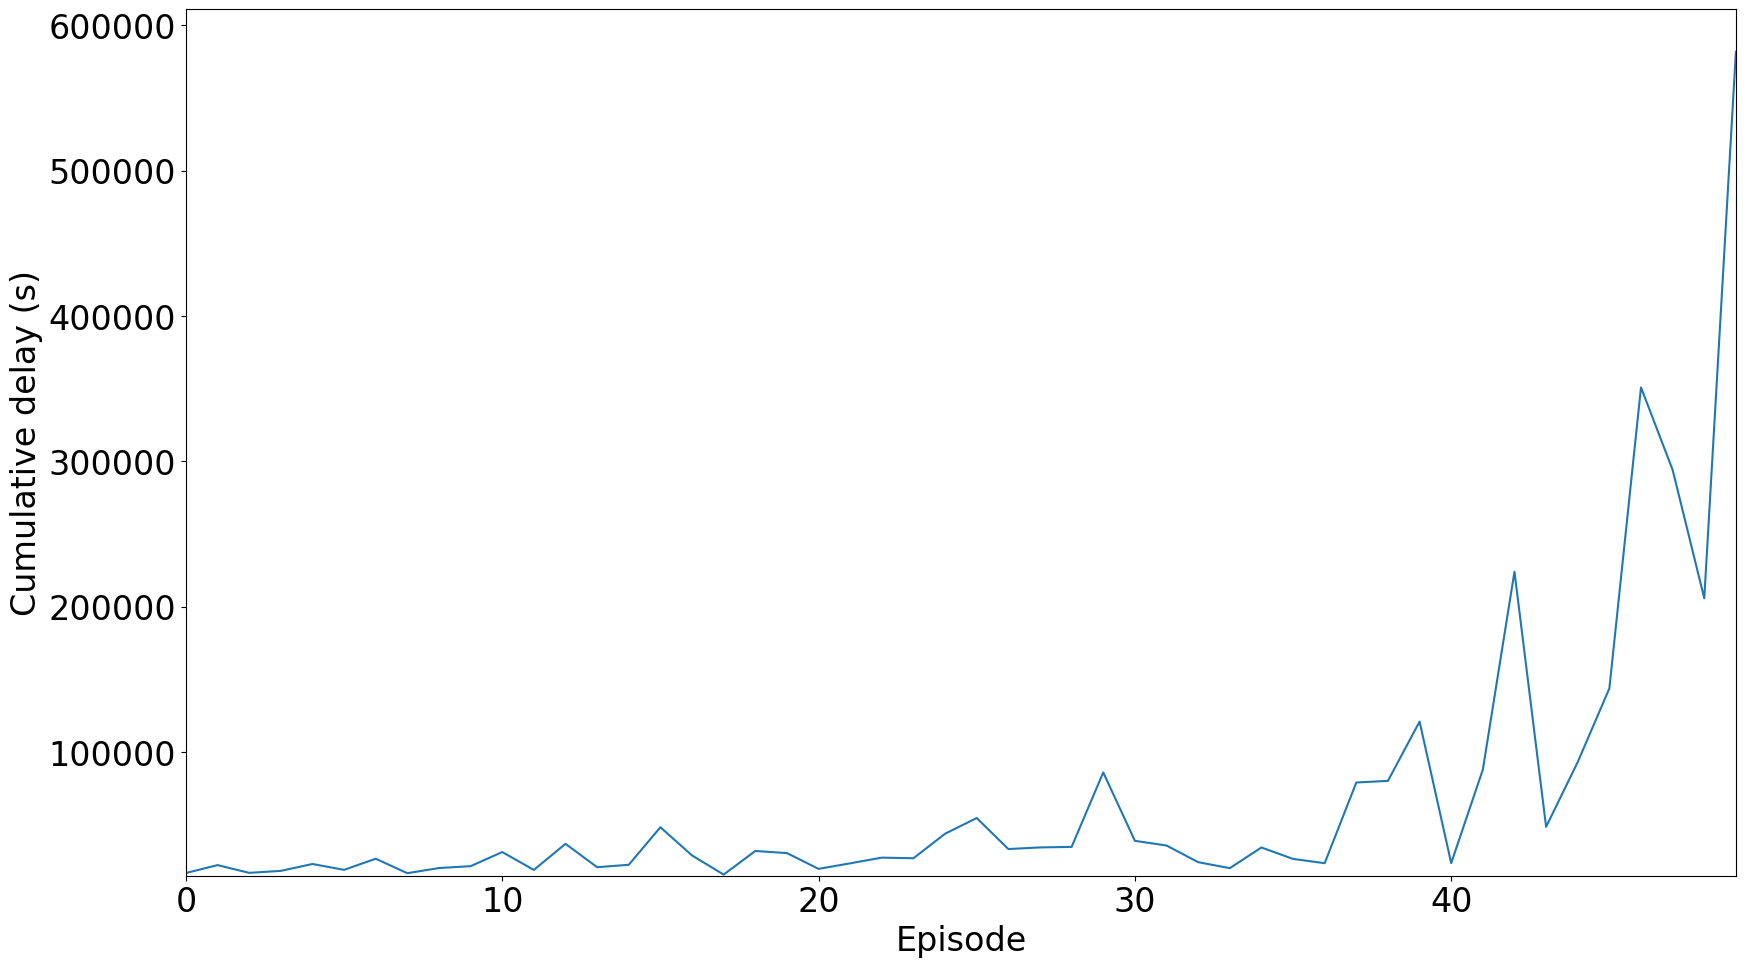

In [ ]:
visualizer.save_data_and_plot(data=Simulation.cumulative_wait_store, filename='delay', xlabel='Episode', ylabel='Cumulative delay (s)')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\SUMO_CaiDat\\StageLight-main\\StageLight-main\\models\\model_4\\plot_queue.png'

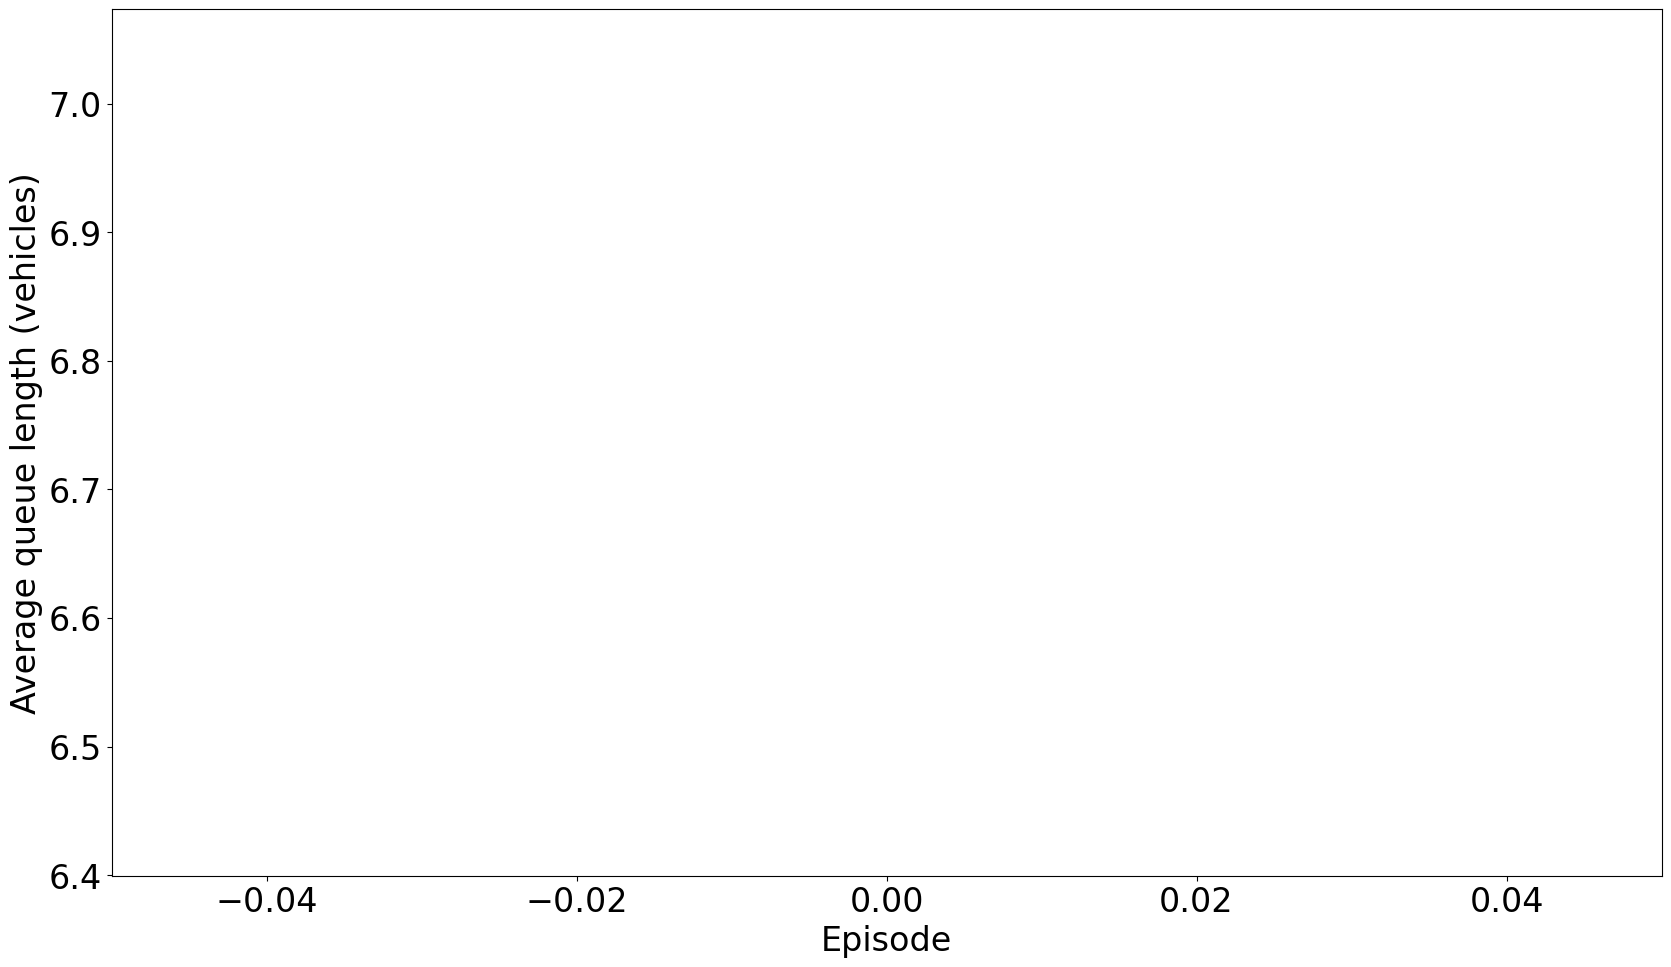

In [ ]:
visualizer.save_data_and_plot(data=Simulation.avg_queue_length_store, filename='queue', xlabel='Episode', ylabel='Average queue length (vehicles)')

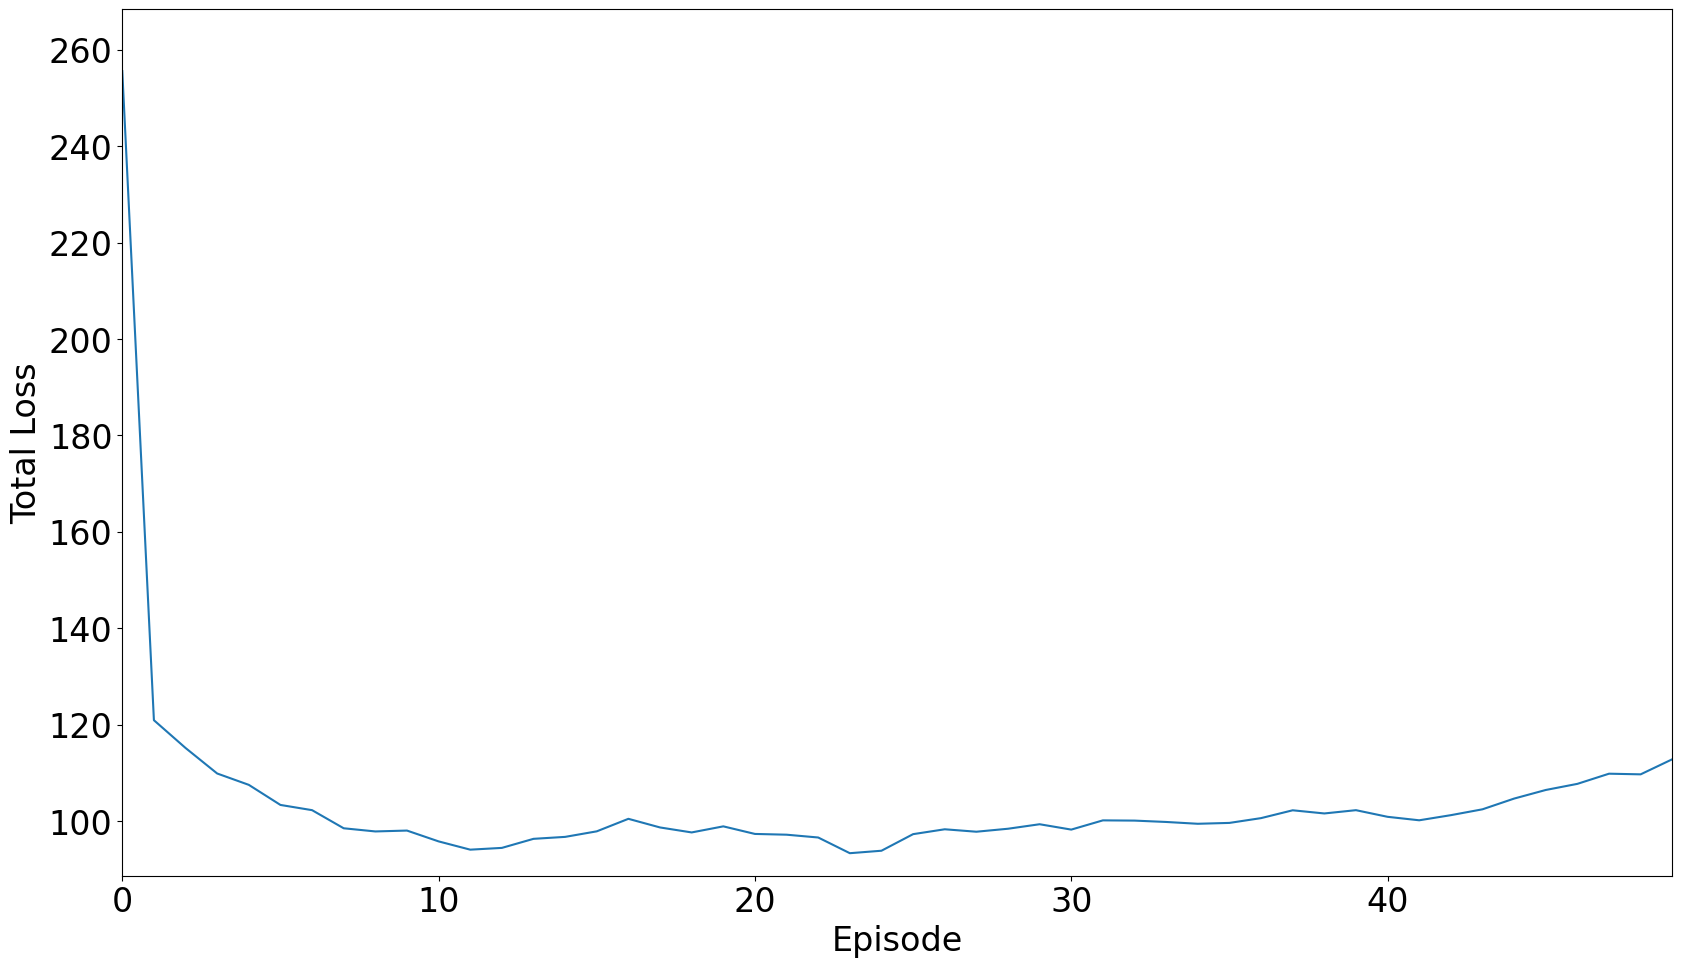

In [ ]:
visualizer.save_data_and_plot(data=Training.loss_store, filename='Loss', xlabel='Episode', ylabel='Total Loss')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\SUMO_CaiDat\\StageLight-main\\StageLight-main\\models\\model_4\\plot_Speed.png'

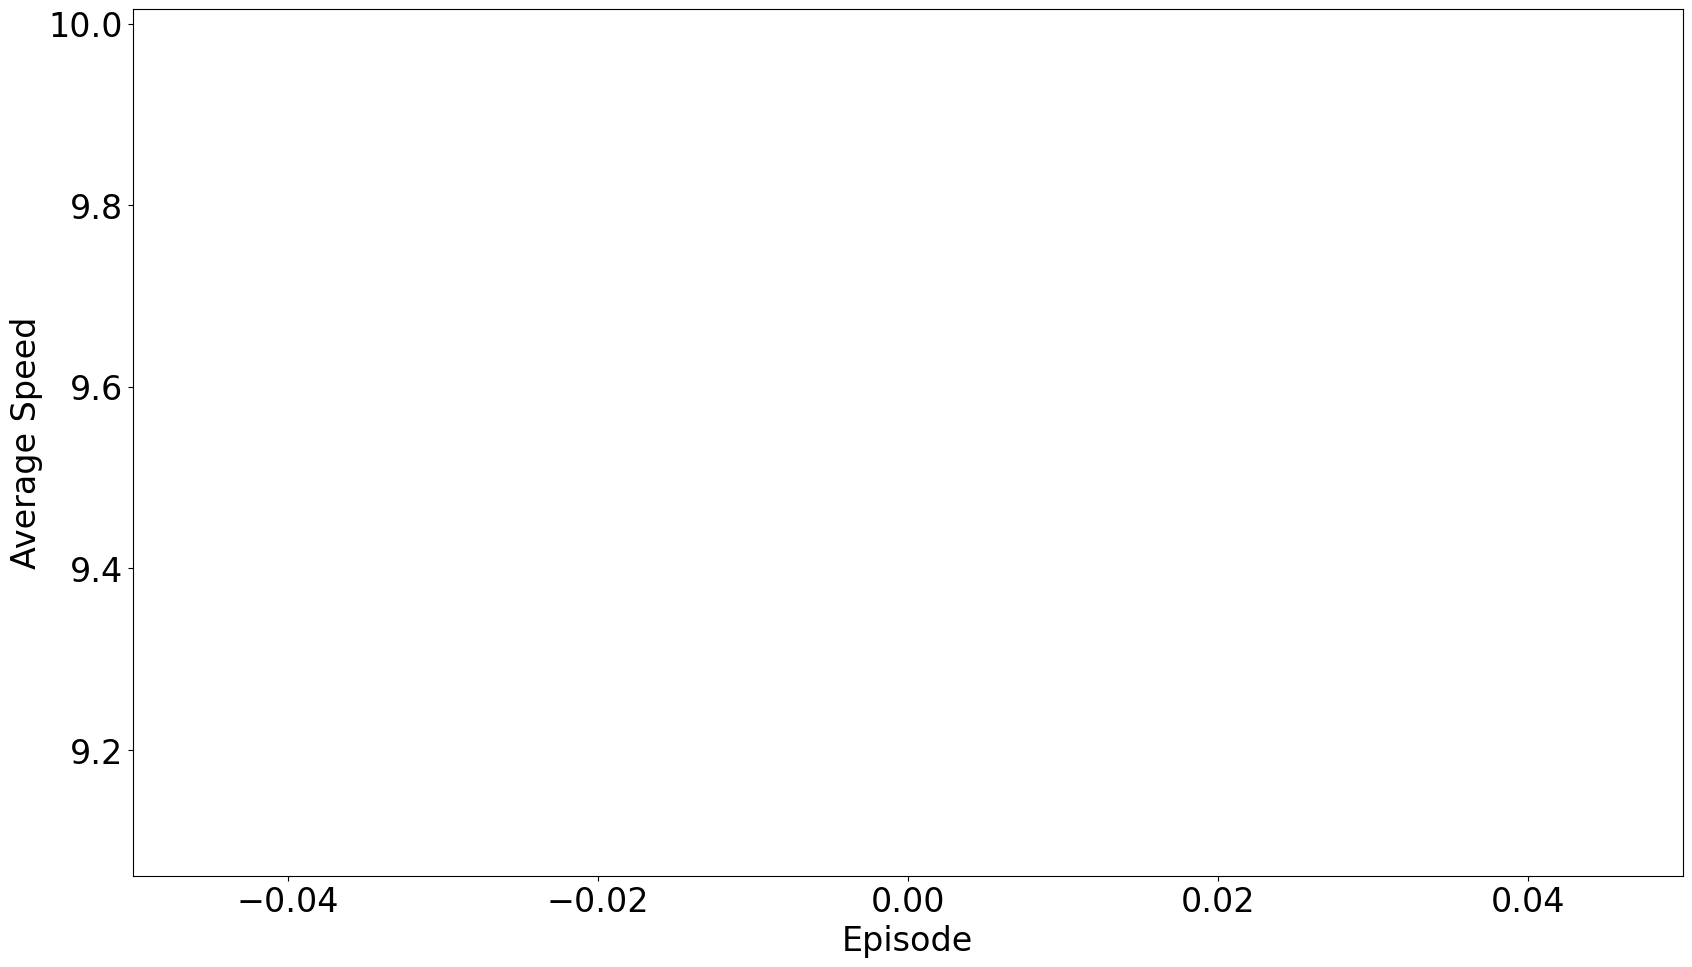

In [27]:
visualizer.save_data_and_plot(data=Simulation.speed_store, filename='Speed', xlabel='Episode', ylabel='Average Speed')

- Categorical 
- Action definition 
- Phase Gate, FRAP 
- Memory Palace for Change-Stay
- Run 3 * 4 model
- not too difference with dones